# MLB Rays - Check Retention Scores
* StellarAlgo Data Science
* Grant Donst
* Aug 29, 2022

In [2]:
import getpass
import pandas as pd
import pyodbc

import matplotlib.pyplot as plt

#from pandas_profiling import ProfileReport
from pycaret.classification import *

### Let's grab the training and eval datasets:

In [3]:
# connect to SQL Server.
SERVER = '54.164.224.129' 
DATABASE = 'datascience' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

In [4]:
lkupclientid = 45 # rays

cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrRays].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

CNXN.commit()
cursor.close()

df.shape

(11212, 53)

In [6]:
df.head()

,lkupClientId,dimCustomerMasterId,year,productGrouping,totalSpent,recentDate,attendancePercent,renewedBeforeDays,isBuyer,source_tenure,tenure,distToVenue,totalGames,recency,missed_games_1,missed_games_2,missed_games_over_2,click_link,fill_out_form,open_email,send_email,unsubscribe_email,openToSendRatio,clickToSendRatio,clickToOpenRatio,posting_records,resale_records,resale_atp,forward_records,cancel_records,email,inbound_email,inbound_phonecall,inperson_contact,internal_note,left_message,outbound_email,outbound_phonecall,phonecall,text,unknown,gender,childrenPresentInHH,maritalStatus,lengthOfResidenceInYrs,annualHHIncome,education,urbanicity,credits_after_refund,is_Lockdown,NumberofGamesPerSeason,CNTPostponedGames,isNextYear_Buyer
0,45,2404,2017,Full Season,14350.00,2017-09-29,0.698758,124,TRUE,6935,306,23.49,60,1,15,4,2,0,0,0,0,0,0.0,0.0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0,2,2,0,0,Unknown,1,1,None,None,None,None,0.0,0,80,None,1
1,45,3726,2017,Partial Season,295.50,2017-08-04,0.700000,124,TRUE,5840,304,47.53,10,4,2,0,1,0,0,0,0,0,0.0,0.0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0,14,14,0,0,Unknown,1,1,None,None,None,None,0.0,0,80,None,1
2,45,4124,2017,Partial Season,850.00,2017-10-01,1.000000,129,TRUE,3285,306,24.32,21,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,Unknown,1,1,None,None,None,None,0.0,0,80,None,1
3,45,11380,2017,Partial Season,1000.50,2017-09-30,0.619048,9,TRUE,4745,190,26.41,13,0,5,0,1,0,0,0,0,0,0.0,0.0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,Unknown,1,1,None,None,None,None,0.0,0,80,None,0
4,45,23237,2017,Partial Season,287.75,2017-08-08,0.583333,140,TRUE,5475,252,34.38,5,0,2,0,1,0,0,0,0,0,0.0,0.0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0,8,8,0,0,Unknown,1,1,None,None,None,None,0.0,0,80,None,0


In [8]:
features = [
    "recentDate",
    "dimCustomerMasterId",
    "lkupClientId",
    "productGrouping",
    "year",
    "attendancePercent",
    "clickToOpenRatio",
    "clickToSendRatio",
    "distToVenue",
    "inperson_contact",
    "missed_games_1",
    "missed_games_2",
    "missed_games_over_2",
    "openToSendRatio",
    "phonecall",
    "recency",
    "renewedBeforeDays",
    "source_tenure",
    "totalSpent",
    "isNextYear_Buyer"
]

# choose features for each train dataset
df = df[features]

df["year"] = pd.to_numeric(df["year"])

In [9]:
df_train = df[df["year"] <= 2021]

print(df_train["year"].value_counts())

2021    2593
2017    1840
2019    1840
2018    1825
Name: year, dtype: int64


In [10]:
print(df_train["isNextYear_Buyer"].value_counts())

1    5574
0    2524
Name: isNextYear_Buyer, dtype: int64


### Let's set up our new model:

In [11]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    date_features=[
        "recentDate"
    ],
    ignore_features=[
        "dimCustomerMasterId",
        "lkupClientId",
        "productGrouping",
        "year"
    ],
    numeric_features=[
        "attendancePercent",
        "clickToOpenRatio",
        "clickToSendRatio",
        "distToVenue",
        "inperson_contact",
        "missed_games_1",
        "missed_games_2",
        "missed_games_over_2",
        "openToSendRatio",
        "phonecall",
        "recency",
        "renewedBeforeDays",
        "source_tenure",
        "totalSpent"
    ],
    silent=True,
    verbose=False
);

best_model = compare_models(
    fold=10,
    include=["lightgbm"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7694,0.8049,0.8723,0.8068,0.8382,0.4393,0.4437,0.8090


### Let's finalize our new model so it can be used to make predictions:

In [12]:
final_model = create_model(best_model)
new_retention_model = finalize_model(final_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7620,0.8077,0.8686,0.8008,0.8333,0.4195,0.4238
1,0.7417,0.7730,0.8538,0.7871,0.8191,0.3699,0.3737
2,0.7591,0.7834,0.8644,0.8000,0.8310,0.4139,0.4177
3,0.7631,0.8060,0.8450,0.8156,0.8300,0.4395,0.4403
4,0.7703,0.8165,0.8662,0.8111,0.8378,0.4462,0.4490
5,0.7718,0.8101,0.8726,0.8091,0.8396,0.4461,0.4500
6,0.7951,0.8359,0.8896,0.8248,0.8560,0.5026,0.5069
7,0.7718,0.8025,0.8726,0.8091,0.8396,0.4461,0.4500
8,0.7602,0.7823,0.8811,0.7920,0.8342,0.4055,0.4131
9,0.7994,0.8316,0.9087,0.8184,0.8612,0.5034,0.5125


### Let's use the new and existing model to make predictions on the 2022 season:

In [13]:
df_inference = df[df["year"] >= 2022]

In [14]:
df_inference["year"].value_counts()

2022    3114
Name: year, dtype: int64

### Let's use our model to make predictions on the inference data:

In [15]:
df_predictions = predict_model(new_retention_model, data=df_inference, raw_score=True)

In [16]:
df_predictions.head()

,recentDate,dimCustomerMasterId,lkupClientId,productGrouping,year,attendancePercent,clickToOpenRatio,clickToSendRatio,distToVenue,inperson_contact,...,openToSendRatio,phonecall,recency,renewedBeforeDays,source_tenure,totalSpent,isNextYear_Buyer,Label,Score_0,Score_1
8098,2022-08-24,7905,45,Partial Season,2022,1.133333,0.250000,0.238095,3.28,0,...,0.952381,0,0,4,1095,1386.0,1,1,0.4519,0.5481
8099,2022-08-03,12059,45,Partial Season,2022,0.714286,0.069767,0.055556,36.72,0,...,0.796296,0,0,116,2190,2816.0,1,1,0.4744,0.5256
8100,1970-01-01,13229,45,Membership Bronze,2022,0.000000,0.200000,0.433333,137.63,0,...,2.166667,0,0,379,2190,2000.0,1,1,0.3462,0.6538
8101,1970-01-01,16618,45,Membership Silver,2022,0.000000,0.175676,0.236364,296.38,0,...,1.345455,0,0,302,365,4000.0,0,0,0.5442,0.4558
8102,1970-01-01,22300,45,Membership Bronze,2022,0.000000,0.250000,0.088235,10.03,0,...,0.352941,0,0,372,2190,500.0,1,1,0.3715,0.6285


### Let's visualize the data and see the prediction scores for fans that will renew:

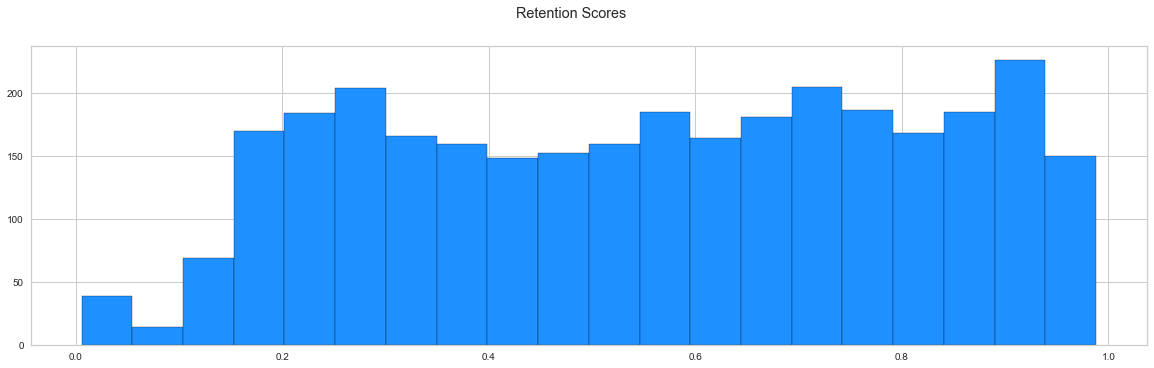

In [17]:
fig, (ax1) = plt.subplots(1, 1)
fig.suptitle('Retention Scores')
ax1.hist(df_predictions['Score_1'], bins=20, edgecolor='black', color='dodgerblue')

fig.figure.set_figwidth(20)

### We can also generate a report to do some exploratory data analysis on our training dataset:

In [ ]:
#profile = ProfileReport(df_train, minimal=True)
#profile.to_file("pandas-profile-report-2018.html")